In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from typing import List

## Data analysis using Pandas


In [ ]:
# Using pandas to import our apple stock dataset
df = pd.read_csv('aapl.us.txt', parse_dates=['Date'])

In [ ]:
df.shape

(8364, 7)

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [ ]:
df['Date'].min(), df['Date'].max()

(Timestamp('1984-09-07 00:00:00'), Timestamp('2017-11-10 00:00:00'))

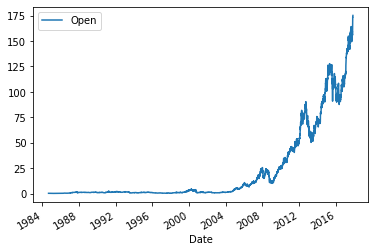

In [ ]:
df.plot(x = 'Date', y = 'Open')

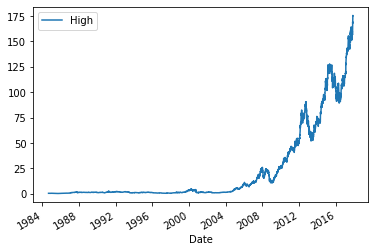

In [ ]:
df.plot(x = 'Date', y = 'High')

In [ ]:
df[['Open', 'Close', 'Low', 'High']].corr()

,Open,Close,Low,High
Open,1.000000,0.999902,0.999942,0.999956
Close,0.999902,1.000000,0.999955,0.999953
Low,0.999942,0.999955,1.000000,0.999928
High,0.999956,0.999953,0.999928,1.000000


In [ ]:
df_6_yr = df[df['Date'] > df['Date'].max() - timedelta(days = 365 * 6)]

In [ ]:
df_6_yr.head()

,Date,Open,High,Low,Close,Volume,OpenInt
6855,2011-11-14,49.187,49.337,48.432,48.570,120687460,0
6856,2011-11-15,48.768,49.880,48.592,49.796,120066631,0
6857,2011-11-16,49.873,50.092,49.217,49.274,97180914,0
6858,2011-11-17,49.167,49.249,48.086,48.333,133785074,0
6859,2011-11-18,48.524,48.663,48.009,48.017,103705732,0


In [ ]:
df_6_yr.shape

(1509, 7)

In [ ]:
df_6_yr['Date'].min(), df_6_yr['Date'].max()

(Timestamp('2011-11-14 00:00:00'), Timestamp('2017-11-10 00:00:00'))

In [ ]:
train_size  = int(df_6_yr.shape[0] * 0.8)
train_df = df_6_yr.iloc[:train_size]
test_df = df_6_yr.iloc[train_size:]

In [ ]:
train_df.shape, test_df.shape

((1207, 7), (302, 7))

In [ ]:
train_df['Date'].min(), train_df['Date'].max(), test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2011-11-14 00:00:00'),
 Timestamp('2016-08-31 00:00:00'),
 Timestamp('2016-09-01 00:00:00'),
 Timestamp('2017-11-10 00:00:00'))

### Creating a dataset for time series

In [ ]:
# scaler is a  PYthon library used for features normalization
scaler = StandardScaler()
scaler.fit(train_df[['Low']])

def make_dataset(df, # input df
                 window_size, #number of elements in time series that are used to predict next element
                 batch_size, # number of elements in the batch used for learning, training
                 use_scaler = True, # Use the scaler or not
                 shuffle = True): # Shuffling the elements in the dataset or not
                 # Need to remove n last elements from dataframe
                 features = df[['Low']].iloc[:-window_size]
                 
                 if use_scaler:
                   features = scaler.transform(features) # Use scaler
                 data = np.array(features, dtype = np.float32)
                 ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                     data = data, 
                     targets = df['Low'].iloc[window_size:],
                     sequence_length = window_size,
                     sequence_stride = 1,
                     shuffle = shuffle,
                     batch_size = batch_size
                 )
                 return ds
                  
                

In [ ]:
example_ds = make_dataset(df = train_df, window_size = 3, batch_size = 2, use_scaler = False, shuffle = False)

In [ ]:
example_feature, example_label = next(example_ds.as_numpy_iterator())

In [ ]:
example_feature.shape

(2, 3, 1)

In [ ]:
example_label.shape

(2,)

In [ ]:
train_df['Low'].iloc[:6]

6855    48.432
6856    48.592
6857    49.217
6858    48.086
6859    48.009
6860    46.860
Name: Low, dtype: float64

In [ ]:
print(example_feature[0])
print(example_label[0])

[[48.432]
 [48.592]
 [49.217]]
48.086000000000006


In [ ]:
print(example_feature[1])
print(example_label[1])

[[48.592]
 [49.217]
 [48.086]]
48.00899999999999


In [ ]:
window_size = 10
batch_size = 8
train_ds = make_dataset(df = train_df, window_size = window_size, batch_size = batch_size , use_scaler = True, shuffle = True)
test_ds = make_dataset(df = test_df, window_size = window_size, batch_size = batch_size , use_scaler = True, shuffle = True)

## Reccurent Neural Network model

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1)
])

In [ ]:
def compile_and_fit(model, train_ds, test_ds, num_epochs: int = 20):
  # Compilational model with loss model of Mean Squared Error, optimization algorithm of Adam and metrics with Mean Absolute Error
  model.compile(
      loss = tf.losses.MeanSquaredError(),
      optimizer = tf.optimizers.Adam(),
      metrics = [tf.metrics.MeanAbsoluteError()]
  )
  # Training of our RNN model
  history = model.fit(
    train_ds, 
    epochs = num_epochs,
    validation_data = test_ds,
    verbose = 0  
  )
  return history

In [ ]:
# Training our model
history = compile_and_fit(lstm_model, train_ds, test_ds, num_epochs = 100)

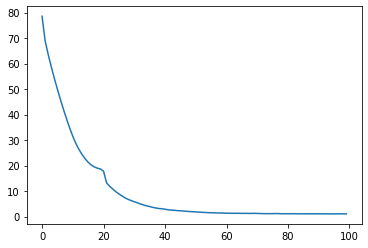

In [ ]:
plt.plot(history.history['mean_absolute_error'])

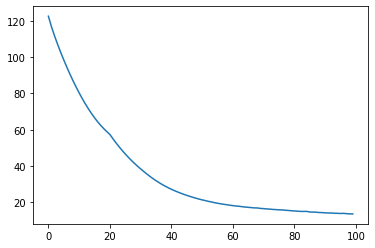

In [ ]:
plt.plot(history.history['val_mean_absolute_error'])

According to our graphs we see that metrics for our training dataset is lower than metrics for our testing dataset which means that there is maybe overfitting in our model

In [ ]:
lstm_model.evaluate(train_ds) 

149/149 [==============================] - 0s 2ms/step - loss: 2.1330 - mean_absolute_error: 0.9977


[2.132997512817383, 0.9977338910102844]

In [ ]:
lstm_model.evaluate(test_ds)

36/36 [==============================] - 0s 2ms/step - loss: 309.4473 - mean_absolute_error: 13.5293


[309.447265625, 13.52931022644043]

According of model evaluation results we see that there is a clear sign of overfitting with train ds evaluation of mean_abs_error being almost 1 and test ds evaluation of mean_abs_error being near 13,5

In [ ]:
lstm_model1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1)
])
history1 = compile_and_fit(lstm_model1, train_ds, test_ds, num_epochs = 500)

In [ ]:
lstm_model1.evaluate(train_ds)

149/149 [==============================] - 0s 2ms/step - loss: 1.6950 - mean_absolute_error: 0.9035


[1.6949591636657715, 0.9034568667411804]

In [ ]:
lstm_model1.evaluate(test_ds)

36/36 [==============================] - 0s 2ms/step - loss: 738.6609 - mean_absolute_error: 20.6332


[738.660888671875, 20.633195877075195]

As a num_epochs value increased from 100 to 500 the mean absolute error value for test_ds evaluation increased from 13.5 to 20.6 which is a clear sign of overfitting due to the large number of epochs

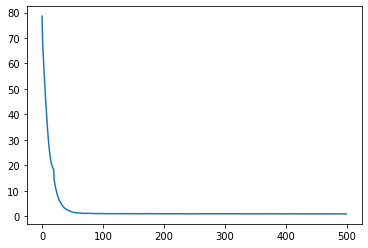

In [ ]:
plt.plot(history1.history['mean_absolute_error'])

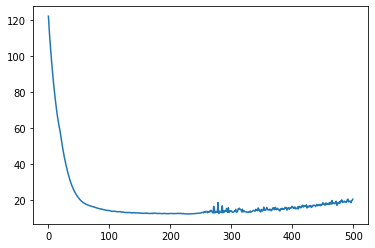

In [ ]:
plt.plot(history1.history['val_mean_absolute_error'])

We see that for of metrics graph of train dataset as num of epochs, as number of epochs increases mean absolute error of training dataset decreases all the way. But for validation dataset mean absolute error as the num of epochs increases till about 250 it decreases, but after that point it fluctuates and starts to increase 

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [ ]:
history = compile_and_fit(lstm_model, train_ds, test_ds, num_epochs = 500)

In order to deal with overfitting of our model, we will use dropout technique and add Dropout layer for our RNN model

In [ ]:
lstm_model.evaluate(train_ds)

149/149 [==============================] - 0s 2ms/step - loss: 2.7774 - mean_absolute_error: 1.2629


[2.777371406555176, 1.2628968954086304]

In [ ]:
lstm_model.evaluate(test_ds)

36/36 [==============================] - 0s 2ms/step - loss: 75.3050 - mean_absolute_error: 6.8229


[75.3050308227539, 6.822933673858643]

As we added dropout layer for our RNN model for the purpose of dealing with overfitting, mean abs error for train dataset of our new model with dropout regularization slightly increased to 1.2, but for test dataset significantly decreased from 20.6 to 6.8

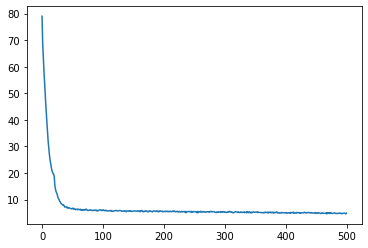

In [ ]:
plt.plot(history.history['mean_absolute_error'])

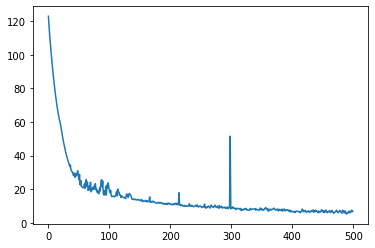

In [ ]:
plt.plot(history.history['val_mean_absolute_error'])